In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

%matplotlib inline

# 1. Load Dataset

In [2]:
df = pd.read_csv("conversion_data.csv")
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [4]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [6]:
for column in df.columns:
    uniques = sorted(df[column].unique())
    print('{0:20s}{1:5d}\t{2}'.format(column, len(uniques), uniques[:10]))

country                 4	['China', 'Germany', 'UK', 'US']
age                    60	[17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
new_user                2	[0, 1]
source                  3	['Ads', 'Direct', 'Seo']
total_pages_visited    29	[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
converted               2	[0, 1]


# 2. Remove Outliers

In [8]:
df['age'].describe()

count    316200.000000
mean         30.569858
std           8.271802
min          17.000000
25%          24.000000
50%          30.000000
75%          36.000000
max         123.000000
Name: age, dtype: float64

In [9]:
df['total_pages_visited'].describe()

count    316200.000000
mean          4.872966
std           3.341104
min           1.000000
25%           2.000000
50%           4.000000
75%           7.000000
max          29.000000
Name: total_pages_visited, dtype: float64

In [10]:
df[df['age'] > 90]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [11]:
# get a new dataframe without outliers
df = df[df['age'] < 100]

# 3. Exploratory Data 

**3.1 Visualizing categorical features**

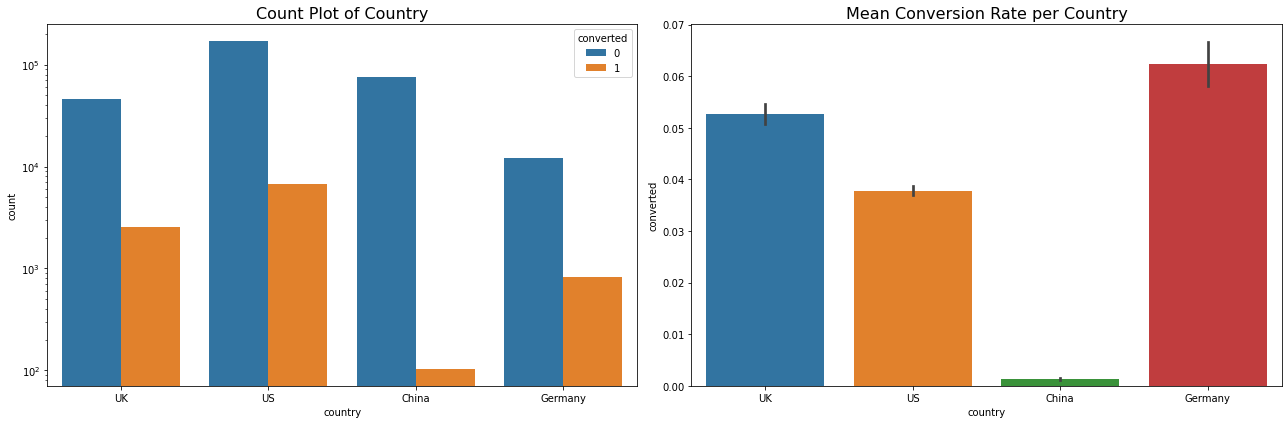

In [12]:
# visualize country feature
grouped = df[['country', 'converted']].groupby('country').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='country', hue='converted', data=df, ax=ax[0])
ax[0].set_title('Count Plot of Country', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='country', y='converted', data=df, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Country', fontsize=16)
plt.tight_layout()
plt.show()

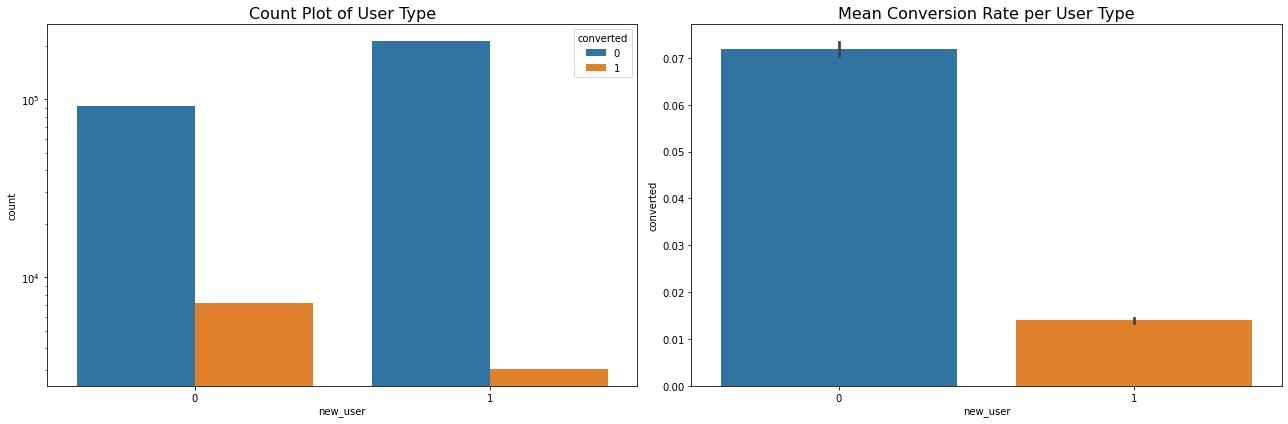

In [14]:
# visualize new_user feature
grouped = df[['new_user', 'converted']].groupby('new_user').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='new_user', hue='converted', data=df, ax=ax[0])
ax[0].set_title('Count Plot of User Type', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='new_user', y='converted', data=df, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per User Type', fontsize=16)
plt.tight_layout()
plt.show()

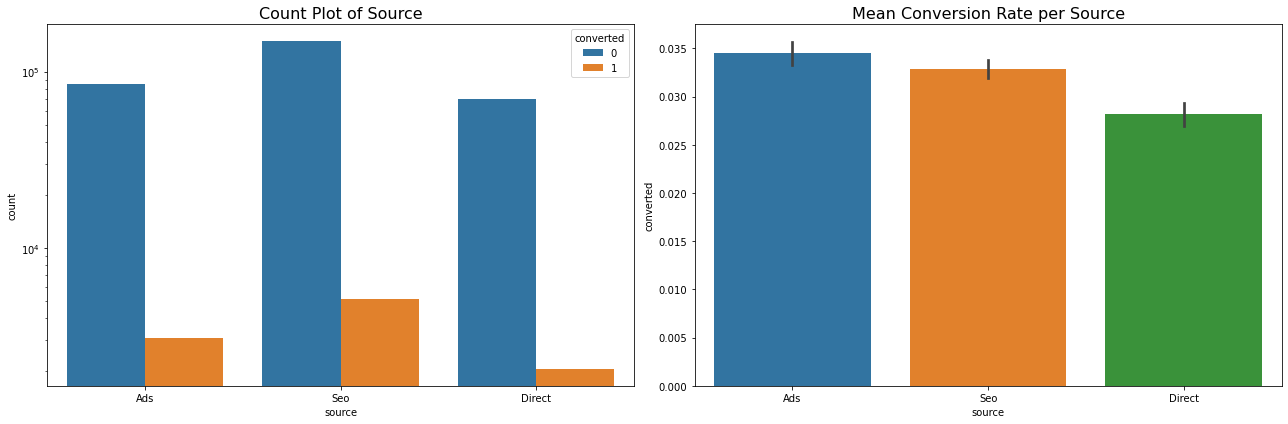

In [15]:
# visualize source feature
grouped = df[['source', 'converted']].groupby('source').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='source', hue='converted', data=df, ax=ax[0])
ax[0].set_title('Count Plot of Source', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='source', y='converted', data=df, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Source',fontsize=16)
plt.tight_layout()
plt.show()

**3.2 Visualizing numerical features**

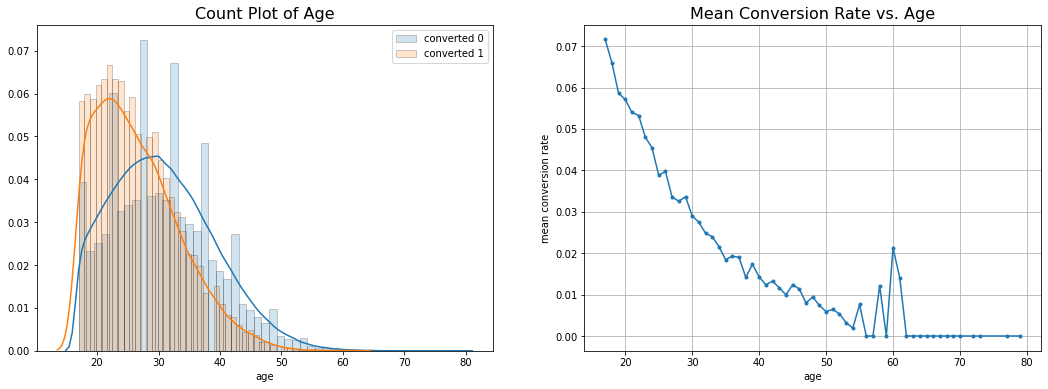

In [16]:
# visualize age feature
grouped = df[['age', 'converted']].groupby('age').mean().reset_index()

hist_kws={'histtype':'bar', 'edgecolor':'black', 'alpha':0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
sns.distplot(df[df['converted'] == 0]['age'], label = 'converted 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(df[df['converted'] == 1]['age'], label = 'converted 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Age', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['age'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Age', fontsize=16)
ax[1].set_xlabel('age')
ax[1].set_ylabel('mean conversion rate')
ax[1].grid(True)
plt.show()

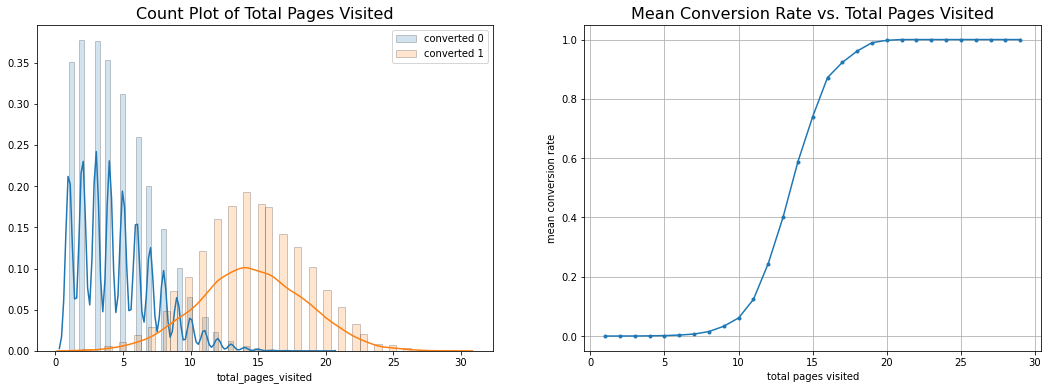

In [17]:
# visualize total_pages_visited feature
grouped = df[['total_pages_visited', 'converted']].groupby('total_pages_visited').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
sns.distplot(df[df['converted'] == 0]['total_pages_visited'], label = 'converted 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(df[df['converted'] == 1]['total_pages_visited'], label = 'converted 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Total Pages Visited', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['total_pages_visited'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Total Pages Visited', fontsize=16)
ax[1].set_xlabel('total pages visited')
ax[1].set_ylabel('mean conversion rate')
ax[1].grid(True)
plt.show()

# 4. Machine Learning

In [18]:
# initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) Client VM (build 25.241-b07, mixed mode)
  Starting server from C:\Users\liang\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\liang\AppData\Local\Temp\tmpexuyv4r_
  JVM stdout: C:\Users\liang\AppData\Local\Temp\tmpexuyv4r_\h2o_liang_started_from_python.out
  JVM stderr: C:\Users\liang\AppData\Local\Temp\tmpexuyv4r_\h2o_liang_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,1 month and 14 days
H2O_cluster_name:,H2O_from_python_liang_uswzwn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,247.5 Mb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [19]:
# transform to H2O Frame, and make sure the target variable is categorical 

h2o_df = H2OFrame(df)

h2o_df['new_user'] = h2o_df['new_user'].asfactor()
h2o_df['converted'] = h2o_df['converted'].asfactor()

h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,country,age,new_user,source,total_pages_visited,converted
type,enum,int,enum,enum,int,enum
mins,,17.0,,,1.0,
mean,,30.5693110013347,,,4.872918234777034,
maxs,,79.0,,,29.0,
sigma,,8.268957596421474,,,3.3410533442156267,
zeros,,0,,,0,
missing,0,0,0,0,0,0
0,UK,25.0,1,Ads,1.0,0
1,US,23.0,1,Seo,5.0,0
2,US,28.0,1,Seo,4.0,0


In [20]:
# split into 75% training and 25% test dataset
strat_split = h2o_df['converted'].stratified_split(test_frac=0.25, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

feature = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
target = 'converted'

In [21]:
# build random forest model

model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=20, 
                                 mtries=-1, seed=42, score_each_iteration=True)

model.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


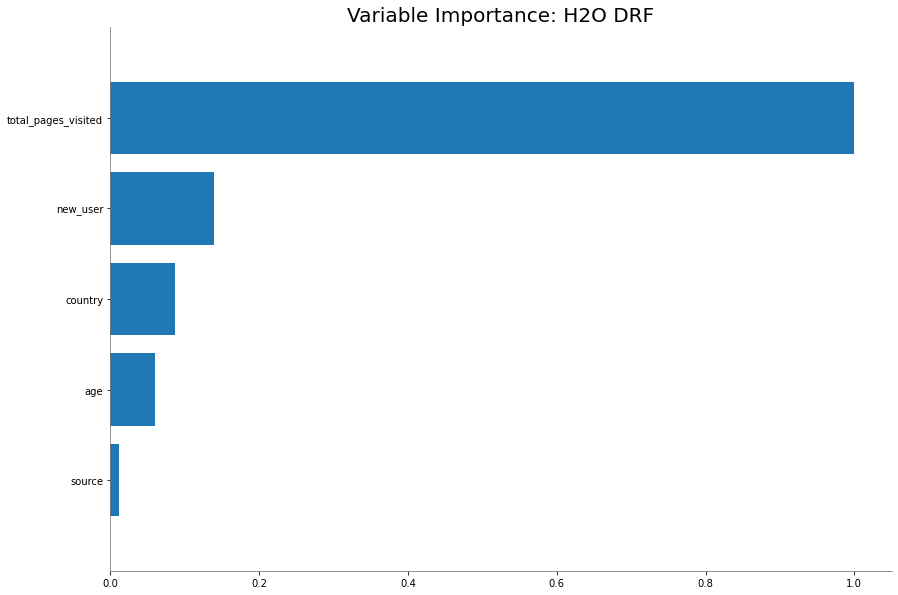

In [22]:
model.varimp_plot()

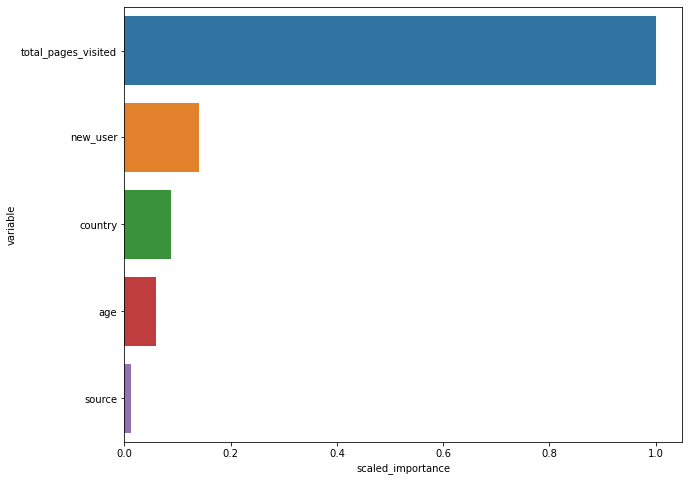

In [23]:
# feature importance

importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()

# “Relative importance” in this context means the proportion of the variance in y accounted for by xj. 
# Put another way, it helps you figure out what variables contribute the most to r-squared.

In [24]:
# make prediction

train_true = train.as_data_frame()['converted'].values
test_true = test.as_data_frame()['converted'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, thresholds = roc_curve(train_true, train_pred)
test_fpr, test_tpr, thresholds = roc_curve(test_true, test_pred)

train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [25]:
# classification report

print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     76500
           1       0.84      0.63      0.72      2550

    accuracy                           0.98     79050
   macro avg       0.91      0.82      0.86     79050
weighted avg       0.98      0.98      0.98     79050



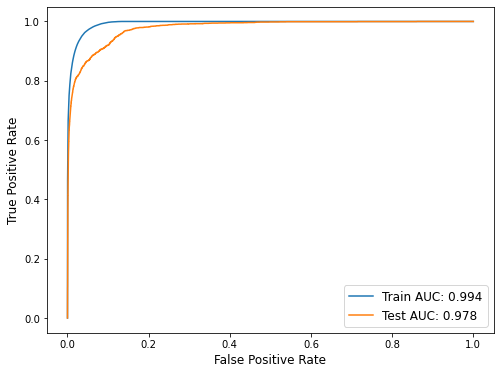

In [26]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


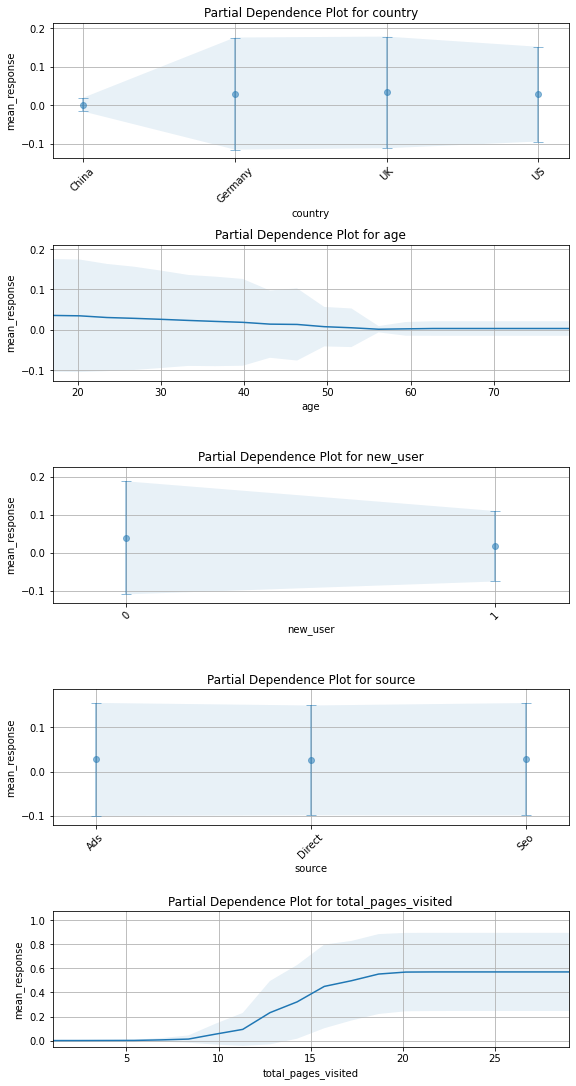

In [27]:
_ = model.partial_plot(train, cols=feature, figsize=(8,15))

# Create partial dependence plot which gives a graphical depiction of the marginal effect of a variable on the response. 
# The effect of a variable is measured in change in the mean response.

In [28]:
# Shutdown h2o instance
h2o.cluster().shutdown()

H2O session _sid_87d9 closed.
